# Análise de resíduos - Geral

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import stats
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import normal_ad, acorr_ljungbox, het_arch
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.regression.linear_model import OLS
from typing import Dict, List, Tuple, Optional, Any
import warnings
warnings.filterwarnings('ignore')

file_path = 'data_updated.csv'

In [56]:
class ResidualAnalysis:
    """Classe para análise de resíduos de modelos de séries temporais"""
    
    def __init__(self, model_name: str, residuals: np.ndarray, 
                 fitted_values: np.ndarray, actual_values: np.ndarray):
        self.model_name = model_name
        self.residuals = np.array(residuals)
        self.fitted_values = np.array(fitted_values)
        self.actual_values = np.array(actual_values)
        self.analysis_results = {}
        
    def comprehensive_residual_analysis(self, lags: int = 20, save_path: Optional[str] = None) -> Dict:
        """Realiza análise completa dos resíduos"""
        print(f"\n{'='*60}")
        print(f"ANÁLISE DE RESÍDUOS: {self.model_name}")
        print(f"{'='*60}")
        
        self._formal_tests(lags)
        self._plot_comprehensive_analysis(lags, save_path)
        self._print_diagnostic_summary()
        
        return self.analysis_results
    
    def _formal_tests(self, lags: int):
        """Executa testes estatísticos formais nos resíduos"""
        try:
            ad_stat, ad_pvalue = normal_ad(self.residuals)
            self.analysis_results['normality_ad'] = {
                'statistic': ad_stat, 'p_value': ad_pvalue, 'is_normal': ad_pvalue > 0.05
            }
        except:
            self.analysis_results['normality_ad'] = {'statistic': np.nan, 'p_value': np.nan, 'is_normal': np.nan}
        
        try:
            lb_test = acorr_ljungbox(self.residuals, lags=[lags], return_df=True)
            self.analysis_results['ljung_box'] = {
                'statistic': lb_test['lb_stat'].iloc[0], 
                'p_value': lb_test['lb_pvalue'].iloc[0], 
                'no_autocorr': lb_test['lb_pvalue'].iloc[0] > 0.05
            }
        except:
            self.analysis_results['ljung_box'] = {'statistic': np.nan, 'p_value': np.nan, 'no_autocorr': np.nan}
        
        try:
            arch_test = het_arch(self.residuals)
            self.analysis_results['arch_test'] = {
                'statistic': arch_test[0], 'p_value': arch_test[1], 'is_homoscedastic': arch_test[1] > 0.05
            }
        except:
            self.analysis_results['arch_test'] = {'statistic': np.nan, 'p_value': np.nan, 'is_homoscedastic': np.nan}
        
        try:
            dw_stat = durbin_watson(self.residuals)
            self.analysis_results['durbin_watson'] = {
                'statistic': dw_stat, 'no_autocorr': 1.5 <= dw_stat <= 2.5
            }
        except:
            self.analysis_results['durbin_watson'] = {'statistic': np.nan, 'no_autocorr': np.nan}
        
        self.analysis_results['descriptive_stats'] = {
            'mean': np.mean(self.residuals),
            'std': np.std(self.residuals),
            'skewness': stats.skew(self.residuals),
            'kurtosis': stats.kurtosis(self.residuals),
            'min': np.min(self.residuals),
            'max': np.max(self.residuals),
            'rmse': np.sqrt(np.mean(self.residuals**2)),
            'mae': np.mean(np.abs(self.residuals)),
            'mse': np.mean(self.residuals**2)
        }
        
        try:
            t_stat, p_value = stats.ttest_1samp(self.residuals, 0)
            self.analysis_results['mean_test'] = {
                't_statistic': t_stat, 'p_value': p_value, 'mean_zero': p_value > 0.05
            }
        except:
            self.analysis_results['mean_test'] = {'t_statistic': np.nan, 'p_value': np.nan, 'mean_zero': np.nan}
    
    def _plot_comprehensive_analysis(self, lags: int, save_path: Optional[str]):
        """Gera gráficos de análise de resíduos"""
        fig = plt.figure(figsize=(20, 12))
        
        plots = [
            (1, 'Resíduos vs Tempo', lambda ax: self._plot_residuals_time(ax)),
            (2, 'Distribuição dos Resíduos', lambda ax: self._plot_residuals_dist(ax)),
            (3, 'Q-Q Plot', lambda ax: qqplot(self.residuals, line='s', ax=ax, alpha=0.7)),
            (4, 'ACF dos Resíduos', lambda ax: plot_acf(self.residuals, lags=lags, ax=ax, alpha=0.05)),
            (5, 'Resíduos vs Valores Ajustados', lambda ax: self._plot_residuals_vs_fitted(ax)),
            (6, 'ACF dos Resíduos²', lambda ax: plot_acf(self.residuals**2, lags=lags, ax=ax, alpha=0.05)),
            (7, 'PACF dos Resíduos', lambda ax: plot_pacf(self.residuals, lags=lags, ax=ax, alpha=0.05)),
            (8, 'Resíduos Padronizados', lambda ax: self._plot_standardized_residuals(ax)),
            (9, 'Resumo Estatístico', lambda ax: self._plot_stats_summary(ax))
        ]
        
        for i, (pos, title, plot_func) in enumerate(plots):
            ax = plt.subplot(3, 3, pos)
            plot_func(ax)
            plt.title(title)
            plt.grid(True, alpha=0.3)
        
        plt.suptitle(f'Análise de Resíduos - {self.model_name}', fontsize=14, fontweight='bold')
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
        plt.show()
    
    def _plot_residuals_time(self, ax):
        plt.plot(self.residuals, 'o-', alpha=0.7, markersize=3)
        plt.axhline(y=0, color='r', linestyle='--', alpha=0.8)
        plt.xlabel('Tempo')
        plt.ylabel('Resíduos')
    
    def _plot_residuals_dist(self, ax):
        plt.hist(self.residuals, bins=25, density=True, alpha=0.7, color='skyblue')
        xmin, xmax = plt.xlim()
        x = np.linspace(xmin, xmax, 100)
        p = stats.norm.pdf(x, np.mean(self.residuals), np.std(self.residuals))
        plt.plot(x, p, 'r-', linewidth=2, label='Normal')
        plt.xlabel('Resíduos')
        plt.ylabel('Densidade')
        plt.legend()
    
    def _plot_residuals_vs_fitted(self, ax):
        plt.scatter(self.fitted_values, self.residuals, alpha=0.6)
        plt.axhline(y=0, color='r', linestyle='--', alpha=0.8)
        plt.xlabel('Valores Ajustados')
        plt.ylabel('Resíduos')
    
    def _plot_standardized_residuals(self, ax):
        standardized_residuals = (self.residuals - np.mean(self.residuals)) / np.std(self.residuals)
        plt.plot(standardized_residuals, 'o-', alpha=0.7, markersize=3)
        plt.axhline(y=0, color='r', linestyle='--', alpha=0.8)
        plt.axhline(y=2, color='orange', linestyle='--', alpha=0.6, label='±2σ')
        plt.axhline(y=-2, color='orange', linestyle='--', alpha=0.6)
        plt.xlabel('Tempo')
        plt.ylabel('Resíduos Padronizados')
        plt.legend()
    
    def _plot_stats_summary(self, ax):
        ax.axis('off')
        stats_text = self._get_stats_text()
        ax.text(0.1, 0.95, stats_text, transform=ax.transAxes, fontsize=10,
                verticalalignment='top', fontfamily='monospace')
    
    def _get_stats_text(self) -> str:
        stats = self.analysis_results
        text = f"Modelo: {self.model_name}\n"
        text += f"Média: {stats['descriptive_stats']['mean']:.4f}\n"
        text += f"Desvio Padrão: {stats['descriptive_stats']['std']:.4f}\n"
        text += f"Assimetria: {stats['descriptive_stats']['skewness']:.4f}\n"
        text += f"Curtose: {stats['descriptive_stats']['kurtosis']:.4f}\n"
        text += f"RMSE: {stats['descriptive_stats']['rmse']:.4f}\n"
        text += f"MAE: {stats['descriptive_stats']['mae']:.4f}\n\n"
        text += f"Normalidade (AD): {stats['normality_ad']['p_value']:.3f}\n"
        text += f"Autocorr (Ljung-Box): {stats['ljung_box']['p_value']:.4f}\n"
        text += f"Heteroced (ARCH): {stats['arch_test']['p_value']:.4f}\n"
        text += f"Durbin-Watson: {stats['durbin_watson']['statistic']:.4f}"
        return text
    
    def _print_diagnostic_summary(self):
        stats = self.analysis_results
        print("\nDIAGNÓSTICO DOS RESÍDUOS:")
        print("-" * 50)
        
        criteria = {
            " Média zero": stats['mean_test']['mean_zero'],
            " Normalidade": stats['normality_ad']['is_normal'],
            " Sem autocorrelação": stats['ljung_box']['no_autocorr'],
            " Homocedasticidade": stats['arch_test']['is_homoscedastic'],
            " Durbin-Watson OK": stats['durbin_watson']['no_autocorr']
        }
        
        print(f"\nERROS:")
        print(f"  RMSE: {stats['descriptive_stats']['rmse']:.4f}")
        print(f"  MAE:  {stats['descriptive_stats']['mae']:.4f}")
        print(f"  MSE:  {stats['descriptive_stats']['mse']:.4f}")
        print("-" * 50)


In [57]:
class BaselineModels:
    @staticmethod
    def fit_mean_model(train: pd.Series, test_length: int) -> Tuple[np.ndarray, np.ndarray]:
        mean_value = train.mean()
        return np.full(test_length, mean_value), np.full(len(train), mean_value)
    
    @staticmethod
    def fit_naive_model(train: pd.Series, test_length: int) -> Tuple[np.ndarray, np.ndarray]:
        last_value = train.iloc[-1]
        return np.full(test_length, last_value), np.full(len(train), last_value)
    
    @staticmethod
    def fit_drift_model(train: pd.Series, test_length: int) -> Tuple[np.ndarray, np.ndarray]:
        drift = (train.iloc[-1] - train.iloc[0]) / max(len(train) - 1, 1)
        predictions = train.iloc[-1] + drift * np.arange(1, test_length + 1)
        fitted = train.iloc[0] + drift * np.arange(len(train))
        return predictions, fitted
    
    @staticmethod
    def fit_rolling_mean_model(train: pd.Series, test_length: int, window: int = 4) -> Tuple[np.ndarray, np.ndarray]:
        rolling_mean = train.rolling(window=window).mean()
        last_value = rolling_mean.iloc[-1] if not pd.isna(rolling_mean.iloc[-1]) else train.mean()
        return np.full(test_length, last_value), rolling_mean.fillna(train.mean()).values
    
    @staticmethod
    def fit_seasonal_naive(train: pd.Series, test_length: int, seasonality: int = 7) -> Tuple[np.ndarray, np.ndarray]:
        seasonal_value = train.iloc[-seasonality] if len(train) >= seasonality else train.iloc[-1]
        return np.full(test_length, seasonal_value), np.full(len(train), seasonal_value)

In [58]:
class StatisticalModels:
    @staticmethod
    def fit_autoregressive_model(train: pd.Series, test_length: int, lags: int = 5) -> Tuple[np.ndarray, np.ndarray]:
        try:
            if len(train) <= lags:
                return BaselineModels.fit_rolling_mean_model(train, test_length, window=min(lags, len(train)))
            
            ar_model = AutoReg(train, lags=lags, old_names=False)
            ar_result = ar_model.fit()
            
            predictions = ar_result.forecast(steps=test_length)
            fitted_values = ar_result.fittedvalues
            
            if len(predictions) < test_length:
                predictions = np.concatenate([predictions, np.repeat(predictions[-1], test_length - len(predictions))])
            
            if len(fitted_values) < len(train):
                fitted_values = np.concatenate([np.full(len(train) - len(fitted_values), np.nan), fitted_values])
            
            print(f"  Modelo AR({lags}) - AIC: {ar_result.aic:.2f}")
            return predictions, fitted_values
        except Exception as e:
            print(f"  Erro no modelo AR: {e}")
            return BaselineModels.fit_rolling_mean_model(train, test_length, window=lags)
    
    @staticmethod
    def fit_exponential_smoothing(train: pd.Series, test_length: int, seasonal_period: int = 7) -> Tuple[np.ndarray, np.ndarray]:
        try:
            if seasonal_period > 0 and len(train) < 2 * seasonal_period:
                seasonal_period = None
            
            if seasonal_period:
                exp_model = ExponentialSmoothing(train, seasonal_periods=seasonal_period, initialization_method='estimated')
            else:
                exp_model = ExponentialSmoothing(train, initialization_method='estimated')
            
            exp_result = exp_model.fit()
            predictions = exp_result.forecast(steps=test_length)
            fitted_values = exp_result.fittedvalues
            
            if len(predictions) < test_length:
                predictions = np.concatenate([predictions, np.repeat(predictions[-1], test_length - len(predictions))])
            
            if len(fitted_values) < len(train):
                fitted_values = np.concatenate([np.full(len(train) - len(fitted_values), np.nan), fitted_values])
            
            print(f"  Modelo Exponencial - AIC: {exp_result.aic:.2f}")
            return predictions, fitted_values
        except Exception as e:
            print(f"  Erro no modelo exponencial: {e}")
            return BaselineModels.fit_rolling_mean_model(train, test_length)


In [59]:
class RegressionModels:
    @staticmethod
    def prepare_covariates(train_data: pd.DataFrame, test_data: pd.DataFrame, target_col: str = 'volume') -> Tuple[pd.DataFrame, pd.DataFrame, List[str]]:
        covariate_cols = []
        train_data = train_data.copy()
        test_data = test_data.copy()
        
        for col in train_data.columns:
            if col != target_col and col != 'week':
                if pd.api.types.is_numeric_dtype(train_data[col]):
                    covariate_cols.append(col)
                elif train_data[col].dtype == bool:
                    train_data[col] = train_data[col].astype(int)
                    test_data[col] = test_data[col].astype(int)
                    covariate_cols.append(col)
        
        if not covariate_cols:
            for lag in [1, 2, 3]:
                train_data[f'lag{lag}'] = train_data[target_col].shift(lag).fillna(train_data[target_col].mean())
                test_data[f'lag{lag}'] = test_data[target_col].shift(lag).fillna(train_data[target_col].mean())
            covariate_cols = [f'lag{lag}' for lag in [1, 2, 3]]
        
        X_train = train_data[covariate_cols].fillna(train_data[covariate_cols].mean())
        X_test = test_data[covariate_cols].fillna(train_data[covariate_cols].mean())
        
        return X_train, X_test, covariate_cols
    
    @staticmethod
    def fit_regression_model(train_data: pd.DataFrame, test_data: pd.DataFrame, target_col: str = 'volume') -> Tuple[np.ndarray, np.ndarray]:
        try:
            X_train, X_test, covariate_cols = RegressionModels.prepare_covariates(train_data, test_data, target_col)
            y_train = train_data[target_col].values
            
            min_len = min(len(X_train), len(y_train))
            X_train = X_train.iloc[:min_len]
            y_train = y_train[:min_len]
            
            if len(X_train) < 2:
                return BaselineModels.fit_mean_model(train_data[target_col], len(test_data))
            
            model = OLS(y_train, X_train)
            result = model.fit()
            
            predictions = result.predict(X_test)
            fitted_values = result.fittedvalues
            
            if len(fitted_values) < len(train_data):
                fitted_values = np.concatenate([np.full(len(train_data) - len(fitted_values), np.nan), fitted_values])
            
            print(f"  Modelo Regressão - R²: {result.rsquared:.4f}")
            return predictions, fitted_values
        except Exception as e:
            print(f"  Erro no modelo regressão: {e}")
            return BaselineModels.fit_mean_model(train_data[target_col], len(test_data))

In [ ]:
class ModelComparator:
    @staticmethod
    def calculate_model_metrics(all_results: Dict) -> pd.DataFrame:
        """Calcula métricas para todos os modelos"""
        metrics_data = []
        for model_name, model_data in all_results.items():
            results = model_data['results']
            
            # Métricas de erro
            rmse = results['descriptive_stats']['rmse']
            mae = results['descriptive_stats']['mae']
            mse = results['descriptive_stats']['mse']
            
            # Critérios de qualidade
            criteria_names = ['Normalidade', 'Autocorrelação', 'Homocedasticidade', 'Durbin-Watson', 'Média Zero']
            criteria_results = [
                results['normality_ad']['is_normal'],
                results['ljung_box']['no_autocorr'],
                results['arch_test']['is_homoscedastic'],
                results['durbin_watson']['no_autocorr'],
                results['mean_test']['mean_zero']
            ]
            
            # Contar critérios atendidos (ignorar NaN)
            criteria_met = sum(1 for r in criteria_results if not np.isnan(r) and r)
            criteria_total = sum(1 for r in criteria_results if not np.isnan(r))
            
            # Status de cada critério
            criteria_status = []
            for r in criteria_results:
                if np.isnan(r):
                    criteria_status.append('N/A')
                elif r:
                    criteria_status.append('OK')
                else:
                    criteria_status.append('FALHA')
            
            metrics_data.append({
                'Modelo': model_name,
                'RMSE': rmse,
                'MAE': mae,
                'MSE': mse,
                'Critérios_Atendidos': f"{criteria_met}/{criteria_total}",
                'Score_Qualidade': criteria_met / criteria_total if criteria_total > 0 else 0,
                'Normalidade': criteria_status[0],
                'Autocorrelação': criteria_status[1],
                'Homocedasticidade': criteria_status[2],
                'Durbin_Watson': criteria_status[3],
                'Média_Zero': criteria_status[4]
            })
        
        return pd.DataFrame(metrics_data)
    
    @staticmethod
    def rank_models_by_error(metrics_df: pd.DataFrame) -> pd.DataFrame:
        """
        Ranking de modelos baseado em erro (RMSE)
        Menor RMSE = melhor (rank mais alto = 1)
        """
        if metrics_df.empty:
            return pd.DataFrame()
        
        # Ordenar por RMSE (menor é melhor)
        ranked_df = metrics_df.sort_values('RMSE').reset_index(drop=True)
        
        # Adicionar ranking (1 é o melhor - menor RMSE)
        ranked_df['Rank'] = range(1, len(ranked_df) + 1)
        
        # Calcular ranking por outras métricas também
        ranked_df['Rank_MAE'] = ranked_df['MAE'].rank(method='min')
        ranked_df['Rank_MSE'] = ranked_df['MSE'].rank(method='min')
        
        # Rank combinado (média dos três rankings)
        ranked_df['Rank_Combinado'] = (ranked_df['Rank'] + ranked_df['Rank_MAE'] + ranked_df['Rank_MSE']) / 3
        
        # Ordenar pelo ranking combinado
        ranked_df = ranked_df.sort_values('Rank_Combinado').reset_index(drop=True)
        ranked_df['Rank_Final'] = range(1, len(ranked_df) + 1)
        
        return ranked_df
    
    @staticmethod
    def plot_model_comparison(ranked_df: pd.DataFrame):
        """Plota comparação entre modelos focando no ranking por erro"""
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # Gráfico 1: RMSE dos modelos (ranking)
        colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(ranked_df)))
        bars = axes[0, 0].barh(range(len(ranked_df)), ranked_df['RMSE'], color=colors, edgecolor='black')
        axes[0, 0].set_yticks(range(len(ranked_df)))
        axes[0, 0].set_yticklabels([f"{r}. {m}" for r, m in zip(ranked_df['Rank_Final'], ranked_df['Modelo'])])
        axes[0, 0].set_xlabel('RMSE (menor é melhor)')
        axes[0, 0].set_title('RMSE por Modelo - Ranking')
        axes[0, 0].invert_yaxis()  # Melhor modelo no topo
        
        # Adicionar valores nas barras
        for i, (bar, rmse) in enumerate(zip(bars, ranked_df['RMSE'])):
            axes[0, 0].text(rmse * 1.01, bar.get_y() + bar.get_height()/2, 
                           f'{rmse:.4f}', va='center', fontsize=9)
        
        # Gráfico 2: Comparação RMSE, MAE, MSE
        x = np.arange(len(ranked_df))
        width = 0.25
        
        axes[0, 1].bar(x - width, ranked_df['RMSE'], width, label='RMSE', alpha=0.7, color='skyblue')
        axes[0, 1].bar(x, ranked_df['MAE'], width, label='MAE', alpha=0.7, color='lightcoral')
        axes[0, 1].bar(x + width, ranked_df['MSE'], width, label='MSE', alpha=0.7, color='lightgreen')
        
        axes[0, 1].set_xlabel('Modelos')
        axes[0, 1].set_ylabel('Valor do Erro')
        axes[0, 1].set_title('Comparação de Métricas de Erro')
        axes[0, 1].set_xticks(x)
        axes[0, 1].set_xticklabels([f"{r}" for r in ranked_df['Rank_Final']], rotation=45)
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3, axis='y')
        
        # Adicionar nomes dos modelos
        for i, (rank, model) in enumerate(zip(ranked_df['Rank_Final'], ranked_df['Modelo'])):
            axes[0, 1].text(i, -0.1, model, ha='center', va='top', fontsize=8, rotation=45)
        
        # Gráfico 4: Tabela de ranking detalhado
        axes[1, 1].axis('off')
        
        # Criar tabela textual
        table_data = []
        for _, row in ranked_df.iterrows():
            table_data.append([
                f"{row['Rank_Final']}",
                row['Modelo'],
                f"{row['RMSE']:.4f}",
                f"{row['MAE']:.4f}",
                f"{row['Critérios_Atendidos']}"
            ])
        
        # Cabeçalho da tabela
        table_text = "RANKING FINAL DE MODELOS\n"
        table_text += "=" * 60 + "\n"
        table_text += f"{'Rank':<5} {'Modelo':<20} {'RMSE':<10} {'MAE':<10}\n"
        table_text += "-" * 60 + "\n"
        
        for row in table_data:
            table_text += f"{row[0]:<5} {row[1]:<20} {row[2]:<10} {row[3]:<10}\n"
        
        # Adicionar legenda de cores para o melhor modelo
        if len(ranked_df) > 0:
            best_model = ranked_df.iloc[0]
            table_text += "\n" + "=" * 60 + "\n"
            table_text += f"MELHOR MODELO: {best_model['Modelo']}\n"
            table_text += f"RMSE: {best_model['RMSE']:.4f} | MAE: {best_model['MAE']:.4f}\n"
            table_text += f"Critérios atendidos: {best_model['Critérios_Atendidos']}"
        
        axes[1, 1].text(0.05, 0.95, table_text, transform=axes[1, 1].transAxes, 
                       fontsize=9, fontfamily='monospace', verticalalignment='top')
        
        plt.suptitle('COMPARAÇÃO E RANKING DE MODELOS - MENOR ERRO (RMSE) É MELHOR', 
                    fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        # Imprimir ranking no console
        print("\n" + "="*80)
        print("RANKING FINAL DE MODELOS (ordenado por RMSE - menor é melhor)")
        print("="*80)
        print(ranked_df[['Rank_Final', 'Modelo', 'RMSE', 'MAE']].to_string(index=False))
        
        # Destacar o melhor modelo
        if len(ranked_df) > 0:
            print("\n" + "="*80)
            print(f" MELHOR MODELO: {ranked_df.iloc[0]['Modelo']}")
            print(f"   RMSE: {ranked_df.iloc[0]['RMSE']:.4f}")
            print(f"   MAE:  {ranked_df.iloc[0]['MAE']:.4f}")
            print("="*80)

In [61]:
# FUNÇÃO PRINCIPAL
def execute_complete_analysis(file_path: str, target_column: str = 'volume', test_size: float = 0.2):
    print("="*80)
    print("ANÁLISE COMPLETA DE MODELOS DE PREVISÃO")
    print("="*80)
    
    # 1. Carregar dados
    print("\n1. CARREGANDO DADOS...")
    try:
        data = pd.read_csv(file_path)
        if 'week' in data.columns:
            data['week'] = pd.to_datetime(data['week'])
            data = data.sort_values('week')
        print(f"   Dataset: {data.shape[0]} linhas, {data.shape[1]} colunas")
        print(f"   Colunas: {list(data.columns)}")
    except Exception as e:
        print(f"   Erro: {e}")
        return None, None, None
    
    # 2. Dividir dados
    print("\n2. DIVIDINDO DADOS...")
    train_size = int(len(data) * (1 - test_size))
    train = data.iloc[:train_size].copy()
    test = data.iloc[train_size:].copy()
    print(f"   Treino: {len(train)} amostras")
    print(f"   Teste:  {len(test)} amostras")
    
    # 3. Ajustar modelos
    print("\n3. AJUSTANDO MODELOS...")
    models_predictions = {}
    test_length = len(test)
    
    # Baseline
    print("\n   A. MODELOS BASELINE:")
    models = [
        ('Mean', BaselineModels.fit_mean_model),
        ('Naive', BaselineModels.fit_naive_model),
        ('Drift', BaselineModels.fit_drift_model),
        ('RollingMean_k4', lambda t, tl: BaselineModels.fit_rolling_mean_model(t, tl, 4)),
        ('SeasonalNaive', lambda t, tl: BaselineModels.fit_seasonal_naive(t, tl, 7))
    ]
    
    for name, func in models:
        pred, fitted = func(train[target_column], test_length)
        models_predictions[name] = pred
        models_predictions[f'{name}_fitted'] = fitted
        print(f"     {name} ajustado")
    
    # Estatísticos
    print("\n   B. MODELOS ESTATÍSTICOS:")
    pred, fitted = StatisticalModels.fit_autoregressive_model(train[target_column], test_length, 5)
    models_predictions['AutoReg_AR5'] = pred
    models_predictions['AutoReg_AR5_fitted'] = fitted
    
    pred, fitted = StatisticalModels.fit_exponential_smoothing(train[target_column], test_length)
    models_predictions['ExponentialSmoothing'] = pred
    models_predictions['ExponentialSmoothing_fitted'] = fitted
    
    # Regressão
    print("\n   C. MODELOS DE REGRESSÃO:")
    pred, fitted = RegressionModels.fit_regression_model(train, test, target_column)
    models_predictions['Regression'] = pred
    models_predictions['Regression_fitted'] = fitted
    
    # 4. Análise de resíduos
    print("\n4. ANÁLISE DE RESÍDUOS...")
    results_dir = Path("./residuals_analysis")
    results_dir.mkdir(exist_ok=True)
    all_results = {}
    
    for model_name in ['Mean', 'Naive', 'Drift', 'RollingMean_k4', 'SeasonalNaive', 
                      'AutoReg_AR5', 'ExponentialSmoothing', 'Regression']:
        
        print(f"\n   Analisando: {model_name}")
        fitted_key = f"{model_name}_fitted"
        
        if fitted_key in models_predictions:
            fitted_values = np.array(models_predictions[fitted_key])
            
            # Tratar dimensões inconsistentes
            if np.isnan(fitted_values).any():
                mask = ~np.isnan(fitted_values)
                if mask.sum() > 0:
                    fitted_clean = fitted_values[mask]
                    train_clean = train[target_column].values[mask]
                    
                    if len(fitted_clean) == len(train_clean):
                        residuals = train_clean - fitted_clean
                        actual_values = train_clean
                    else:
                        min_len = min(len(fitted_clean), len(train_clean))
                        residuals = train_clean[:min_len] - fitted_clean[:min_len]
                        actual_values = train_clean[:min_len]
                else:
                    print(f"     Aviso: Todos valores são NaN")
                    continue
            else:
                # Sem NaN - verificar dimensões
                if len(fitted_values) != len(train):
                    min_len = min(len(fitted_values), len(train))
                    residuals = train[target_column].values[:min_len] - fitted_values[:min_len]
                    actual_values = train[target_column].values[:min_len]
                else:
                    residuals = train[target_column].values - fitted_values
                    actual_values = train[target_column].values
        else:
            predictions = np.array(models_predictions[model_name])
            if len(predictions) != len(test):
                predictions = predictions[:len(test)] if len(predictions) > len(test) else np.concatenate([predictions, np.repeat(predictions[-1], len(test) - len(predictions))])
            
            residuals = test[target_column].values - predictions
            actual_values = test[target_column].values
            fitted_values = predictions
        
        if len(residuals) < 5:
            print(f"     Poucos dados: {len(residuals)} resíduos")
            continue
        
        # Garantir que fitted_values tenha o mesmo tamanho que residuals
        if len(fitted_values) > len(residuals):
            fitted_values = fitted_values[:len(residuals)]
        elif len(fitted_values) < len(residuals):
            fitted_values = np.concatenate([fitted_values, np.full(len(residuals) - len(fitted_values), np.nan)])
        
        analyzer = ResidualAnalysis(model_name, residuals, fitted_values, actual_values)
        save_path = results_dir / f"residuals_{model_name.lower().replace(' ', '_')}.png"
        lags = min(10, len(residuals)//3)
        results = analyzer.comprehensive_residual_analysis(lags=lags, save_path=save_path)
        
        all_results[model_name] = {'results': results, 'residuals': residuals}
    
    if not all_results:
        print("Nenhum modelo analisado.")
        return None, None, None
    
    # 5. Comparação e Ranking
    print("\n5. COMPARAÇÃO E RANKING DE MODELOS...")
    metrics_df = ModelComparator.calculate_model_metrics(all_results)
    ranked_df = ModelComparator.rank_models_by_error(metrics_df)
    ModelComparator.plot_model_comparison(ranked_df)
    print(f"\n Análise concluída!")
    
    return all_results, ranked_df, metrics_df

ANÁLISE COMPLETA DE MODELOS DE PREVISÃO

1. CARREGANDO DADOS...
   Dataset: 157 linhas, 4 colunas
   Colunas: ['week', 'volume', 'inv', 'users']

2. DIVIDINDO DADOS...
   Treino: 125 amostras
   Teste:  32 amostras

3. AJUSTANDO MODELOS...

   A. MODELOS BASELINE:
     Mean ajustado
     Naive ajustado
     Drift ajustado
     RollingMean_k4 ajustado
     SeasonalNaive ajustado

   B. MODELOS ESTATÍSTICOS:
  Modelo AR(5) - AIC: 267.73
  Modelo Exponencial - AIC: -77.92

   C. MODELOS DE REGRESSÃO:
  Modelo Regressão - R²: 0.7051

4. ANÁLISE DE RESÍDUOS...

   Analisando: Mean

ANÁLISE DE RESÍDUOS: Mean


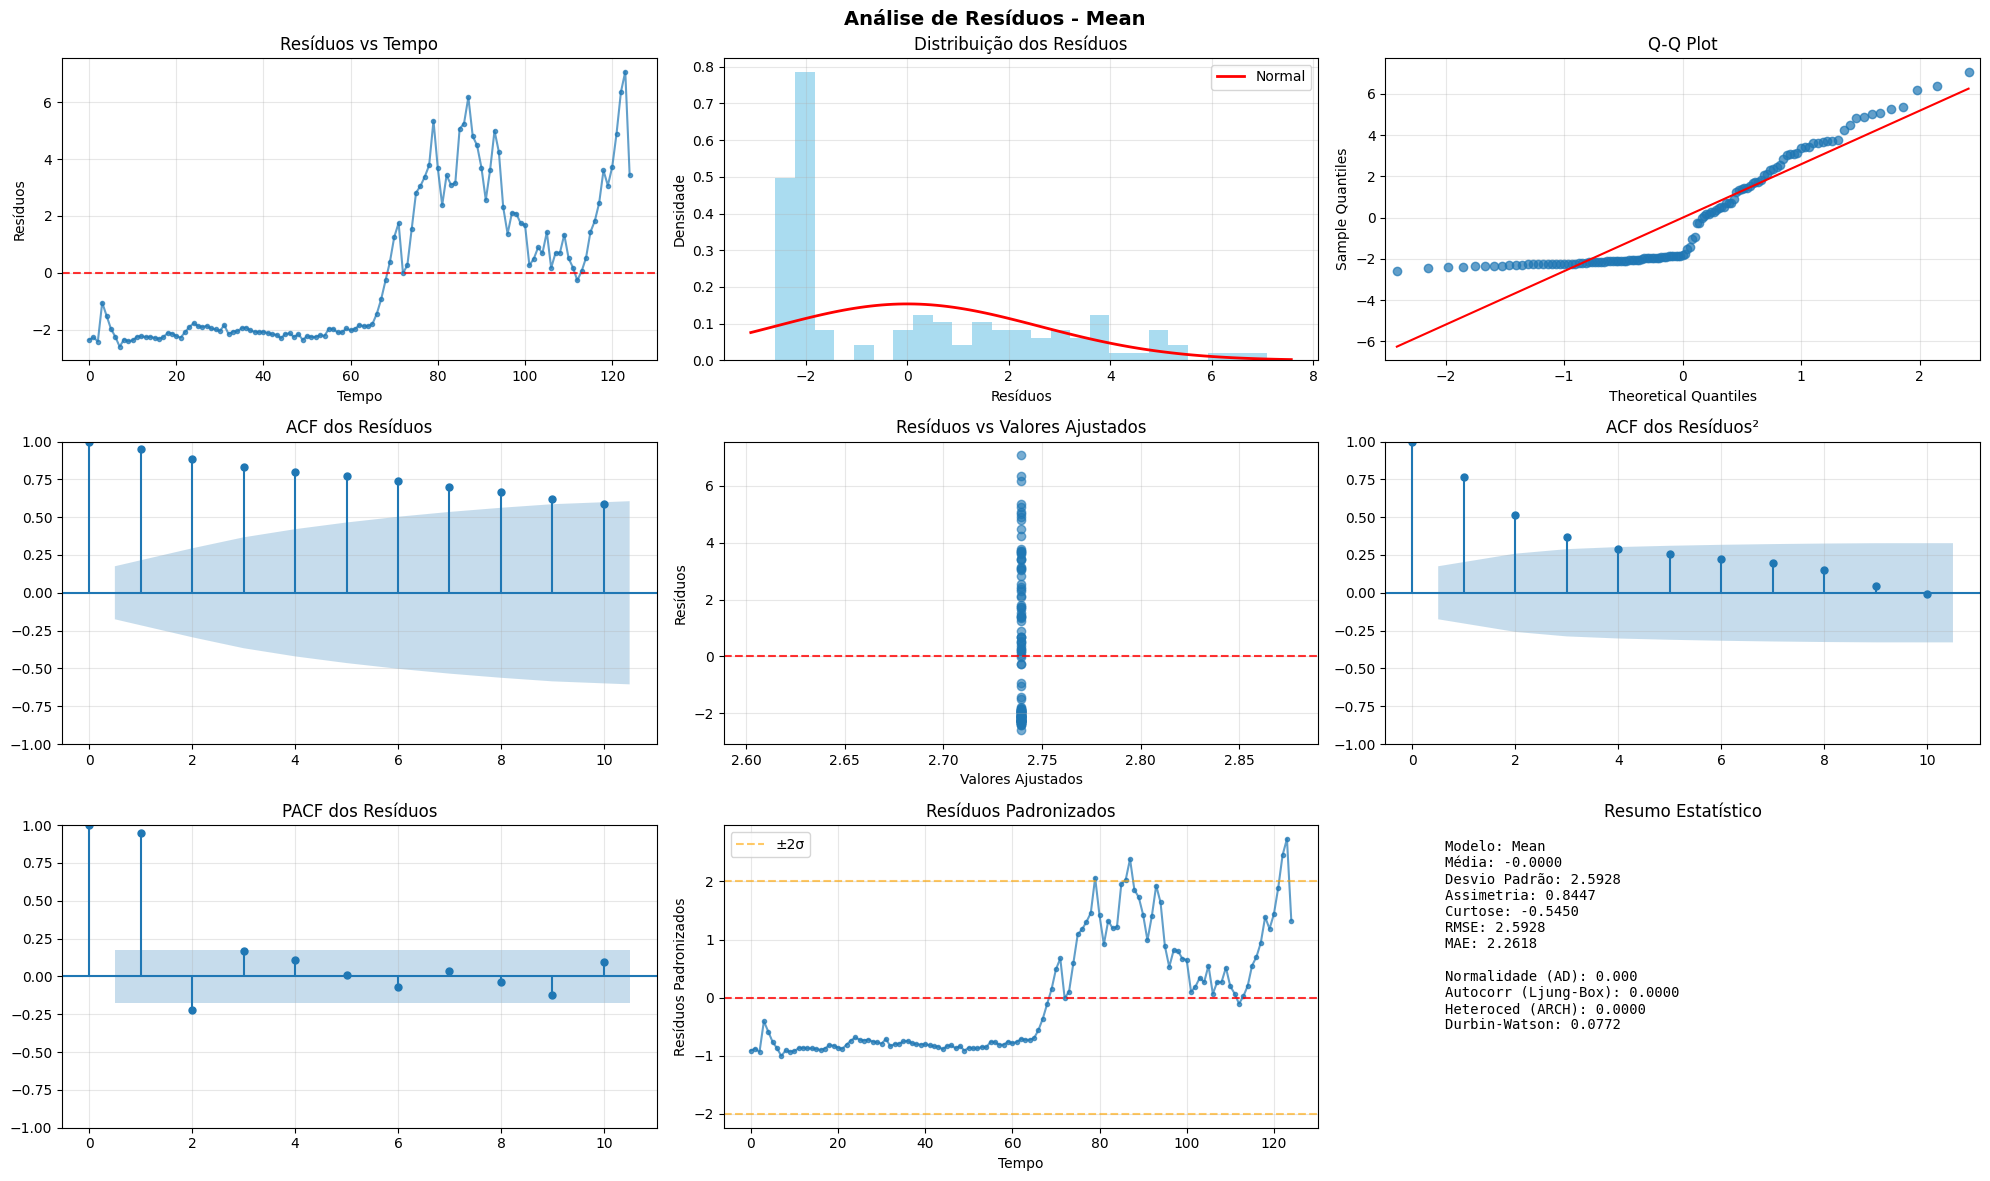


DIAGNÓSTICO DOS RESÍDUOS:
--------------------------------------------------

ERROS:
  RMSE: 2.5928
  MAE:  2.2618
  MSE:  6.7227
--------------------------------------------------

   Analisando: Naive

ANÁLISE DE RESÍDUOS: Naive


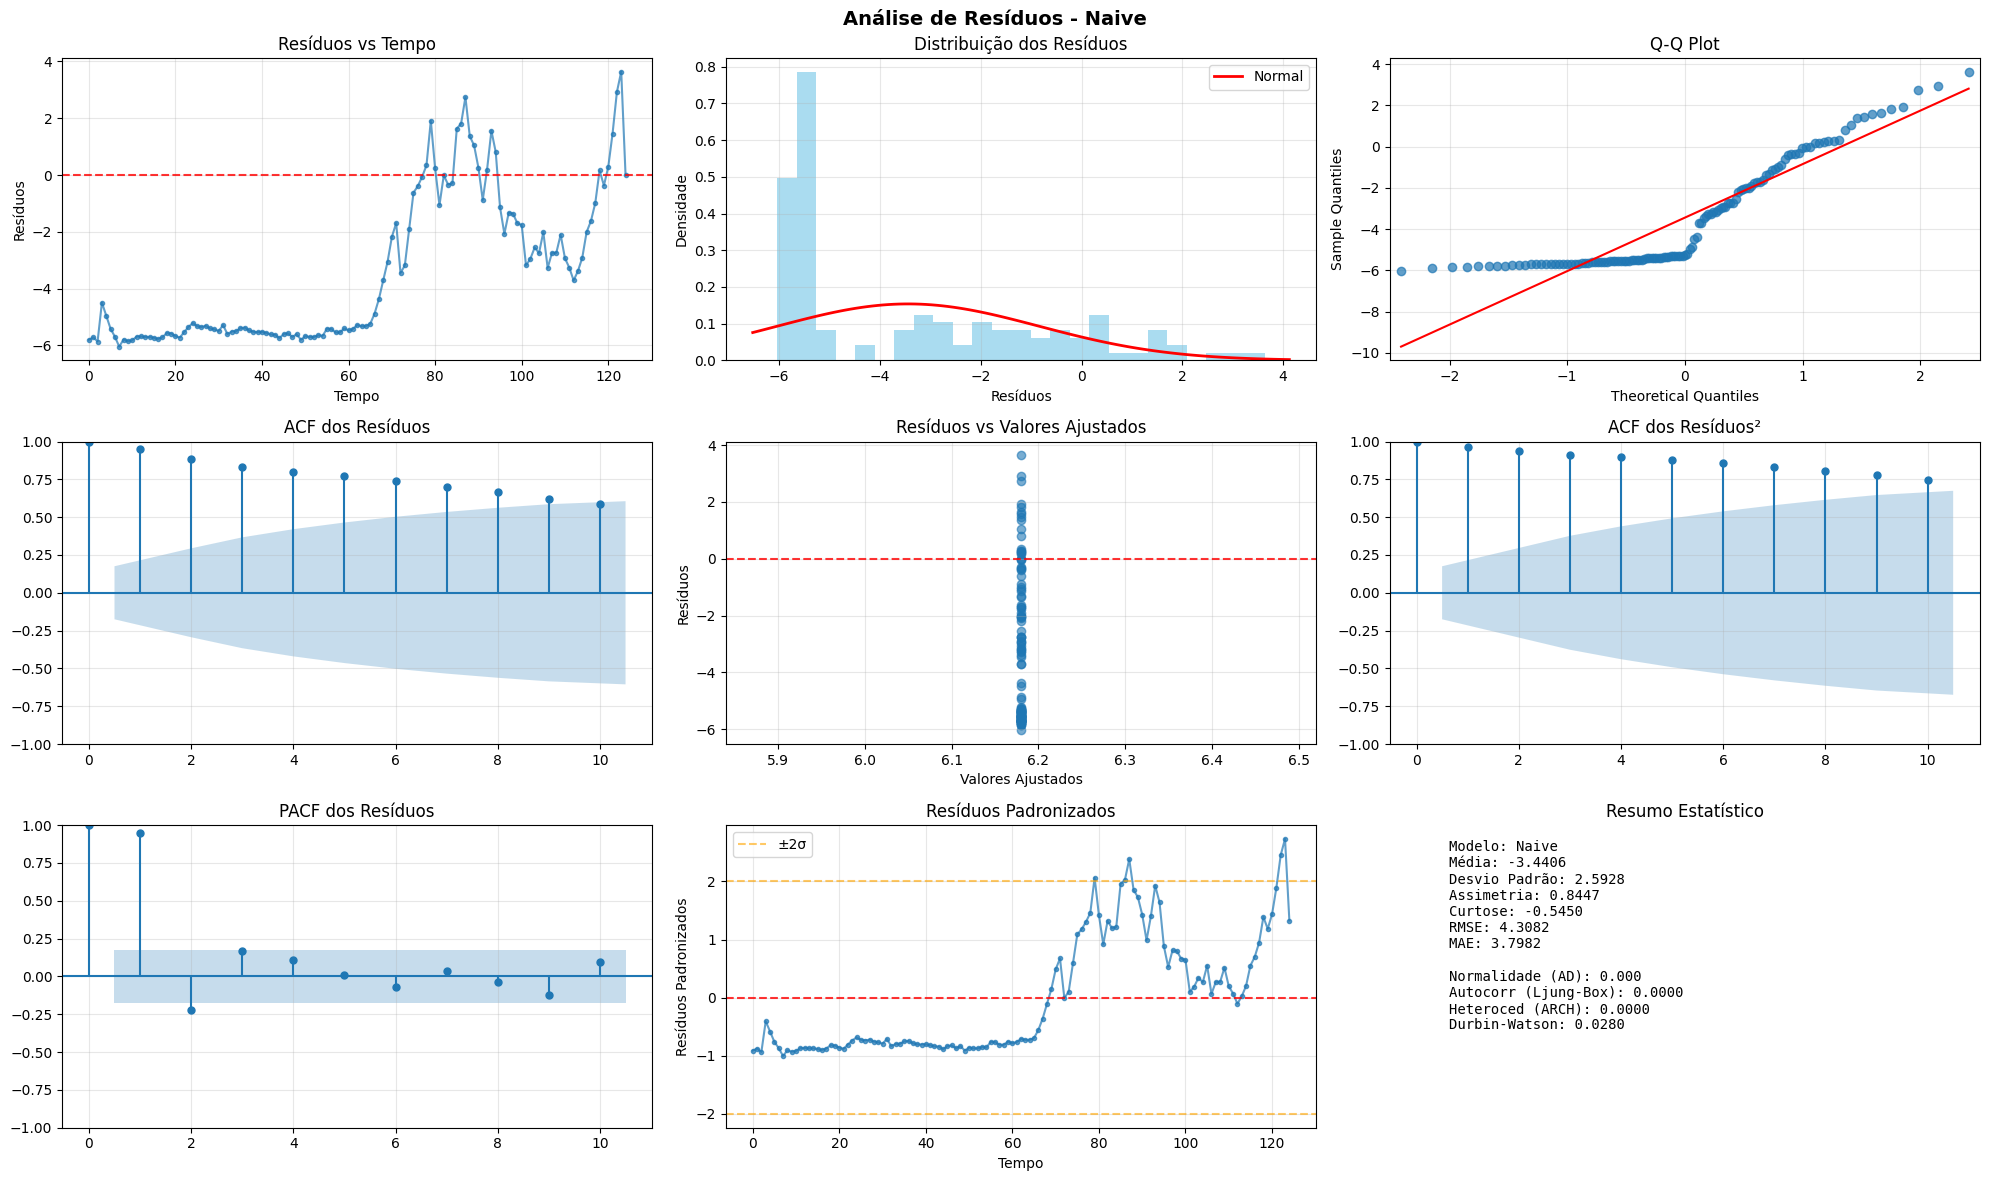


DIAGNÓSTICO DOS RESÍDUOS:
--------------------------------------------------

ERROS:
  RMSE: 4.3082
  MAE:  3.7982
  MSE:  18.5607
--------------------------------------------------

   Analisando: Drift

ANÁLISE DE RESÍDUOS: Drift


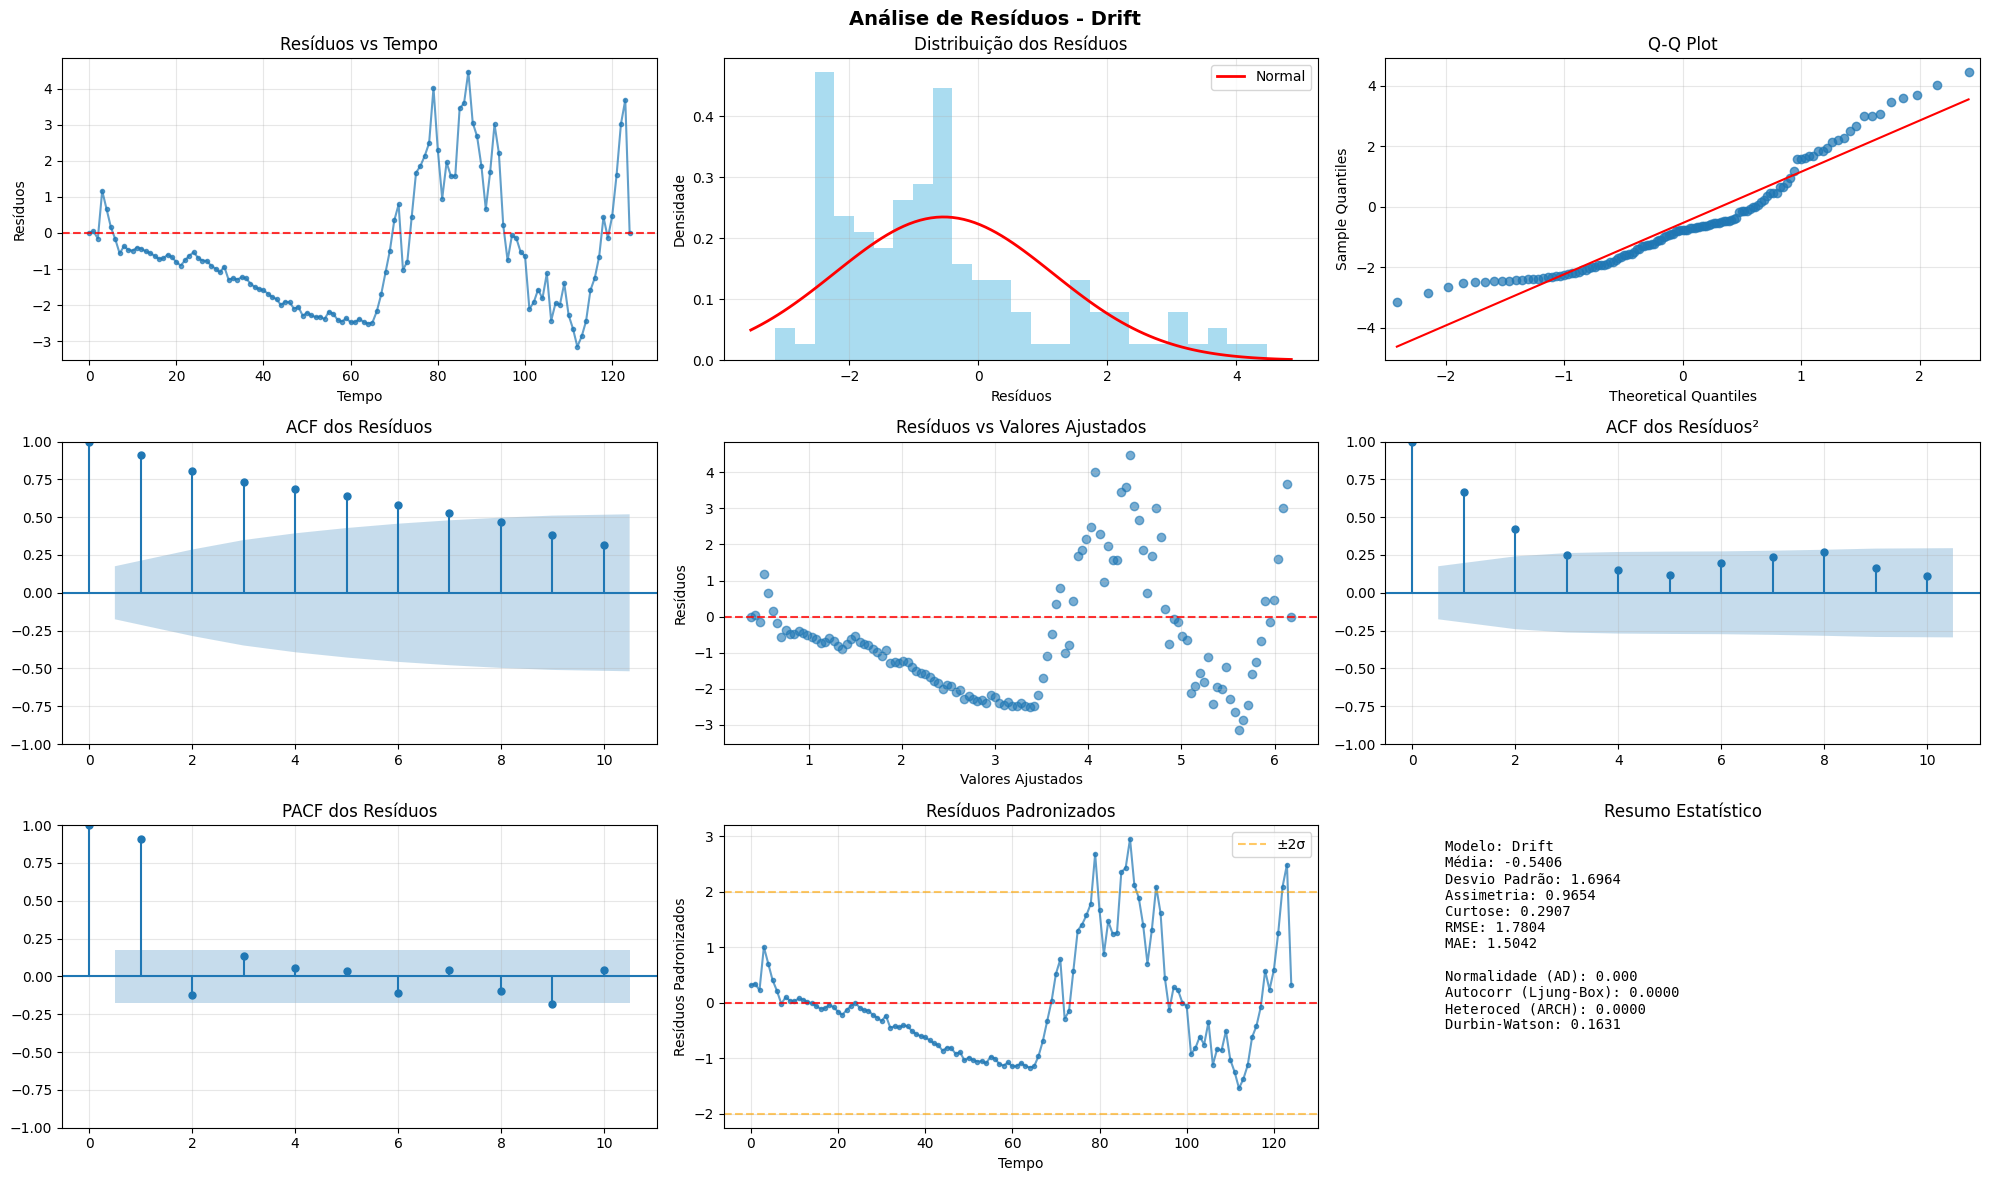


DIAGNÓSTICO DOS RESÍDUOS:
--------------------------------------------------

ERROS:
  RMSE: 1.7804
  MAE:  1.5042
  MSE:  3.1699
--------------------------------------------------

   Analisando: RollingMean_k4

ANÁLISE DE RESÍDUOS: RollingMean_k4


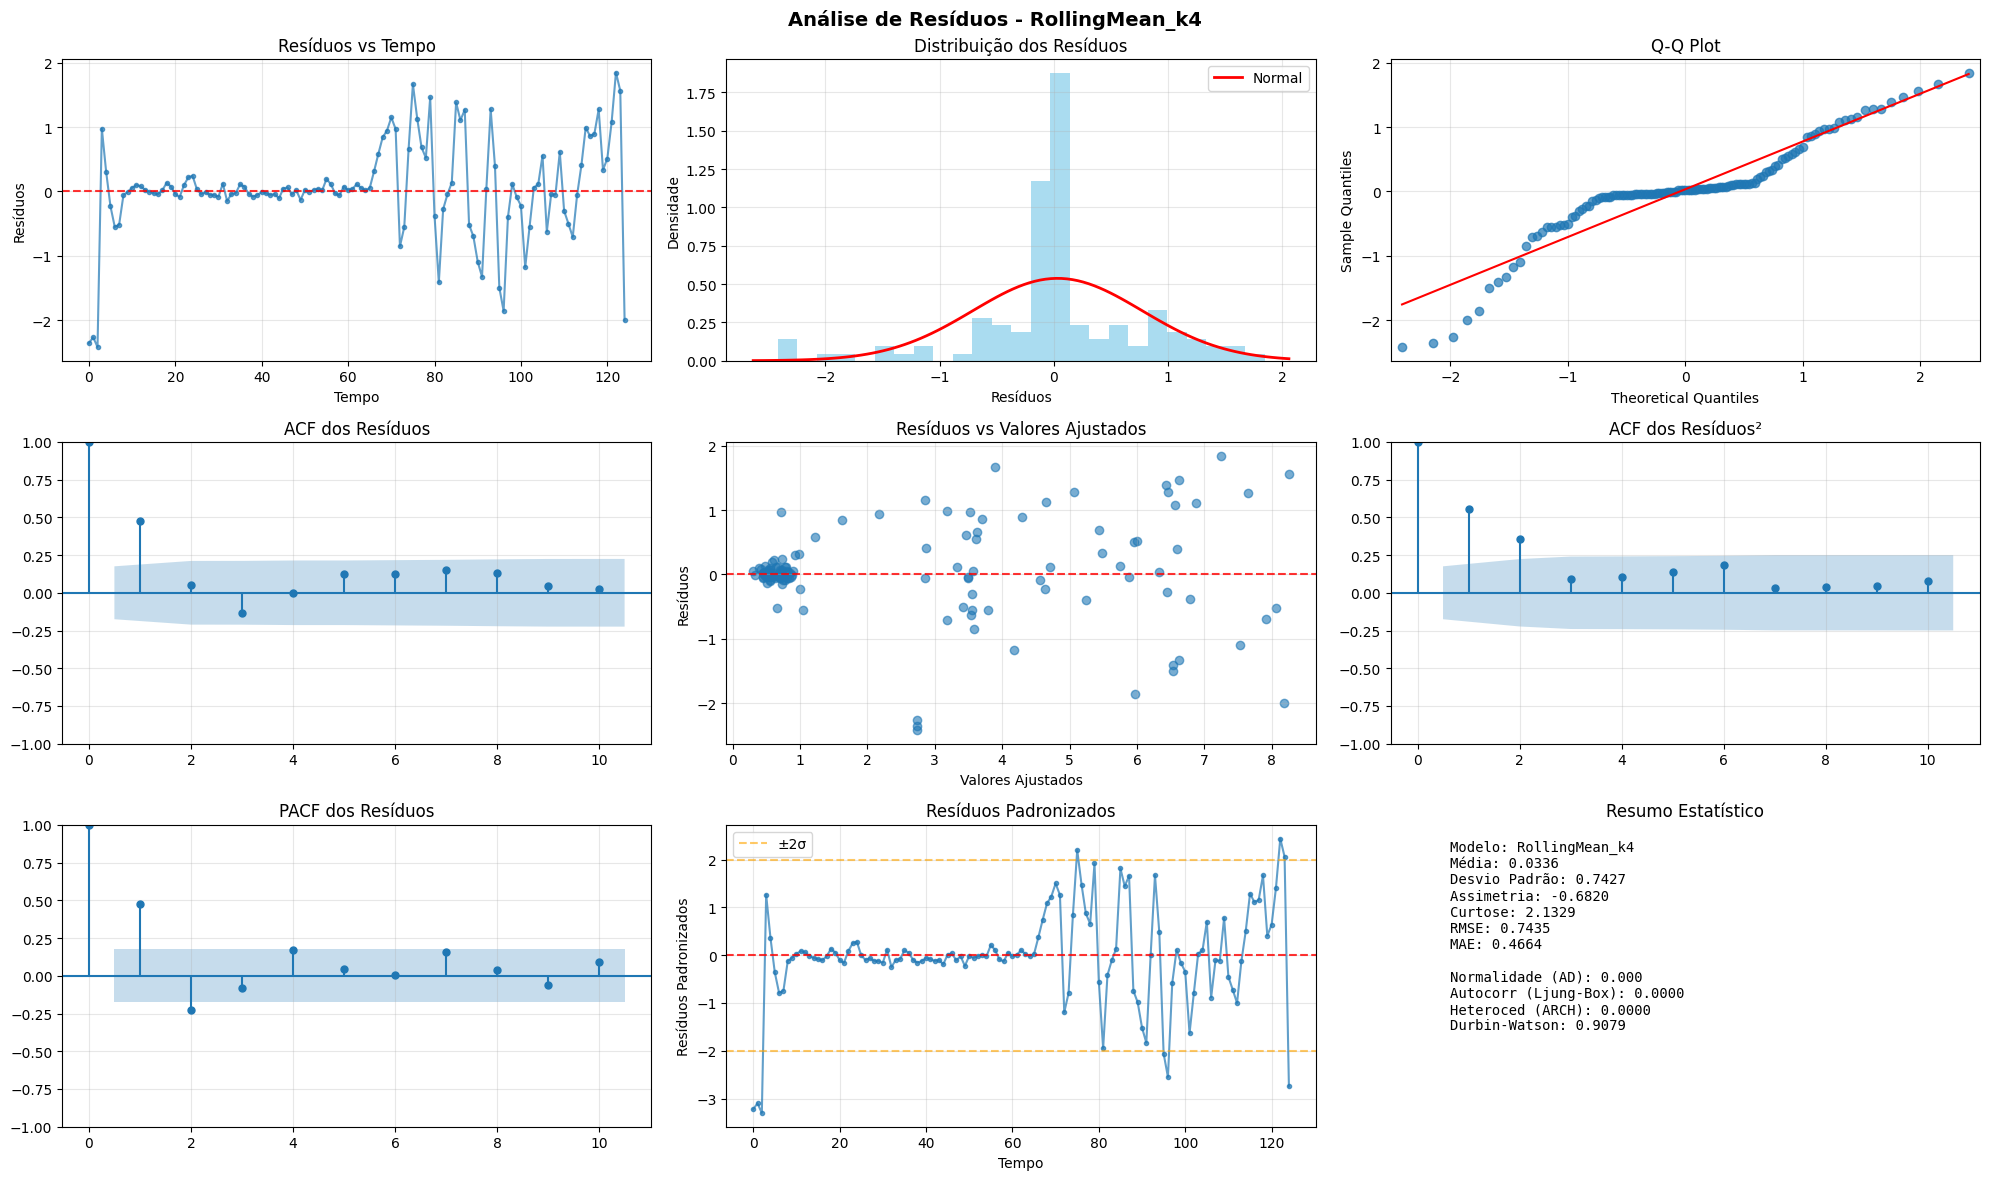


DIAGNÓSTICO DOS RESÍDUOS:
--------------------------------------------------

ERROS:
  RMSE: 0.7435
  MAE:  0.4664
  MSE:  0.5528
--------------------------------------------------

   Analisando: SeasonalNaive

ANÁLISE DE RESÍDUOS: SeasonalNaive


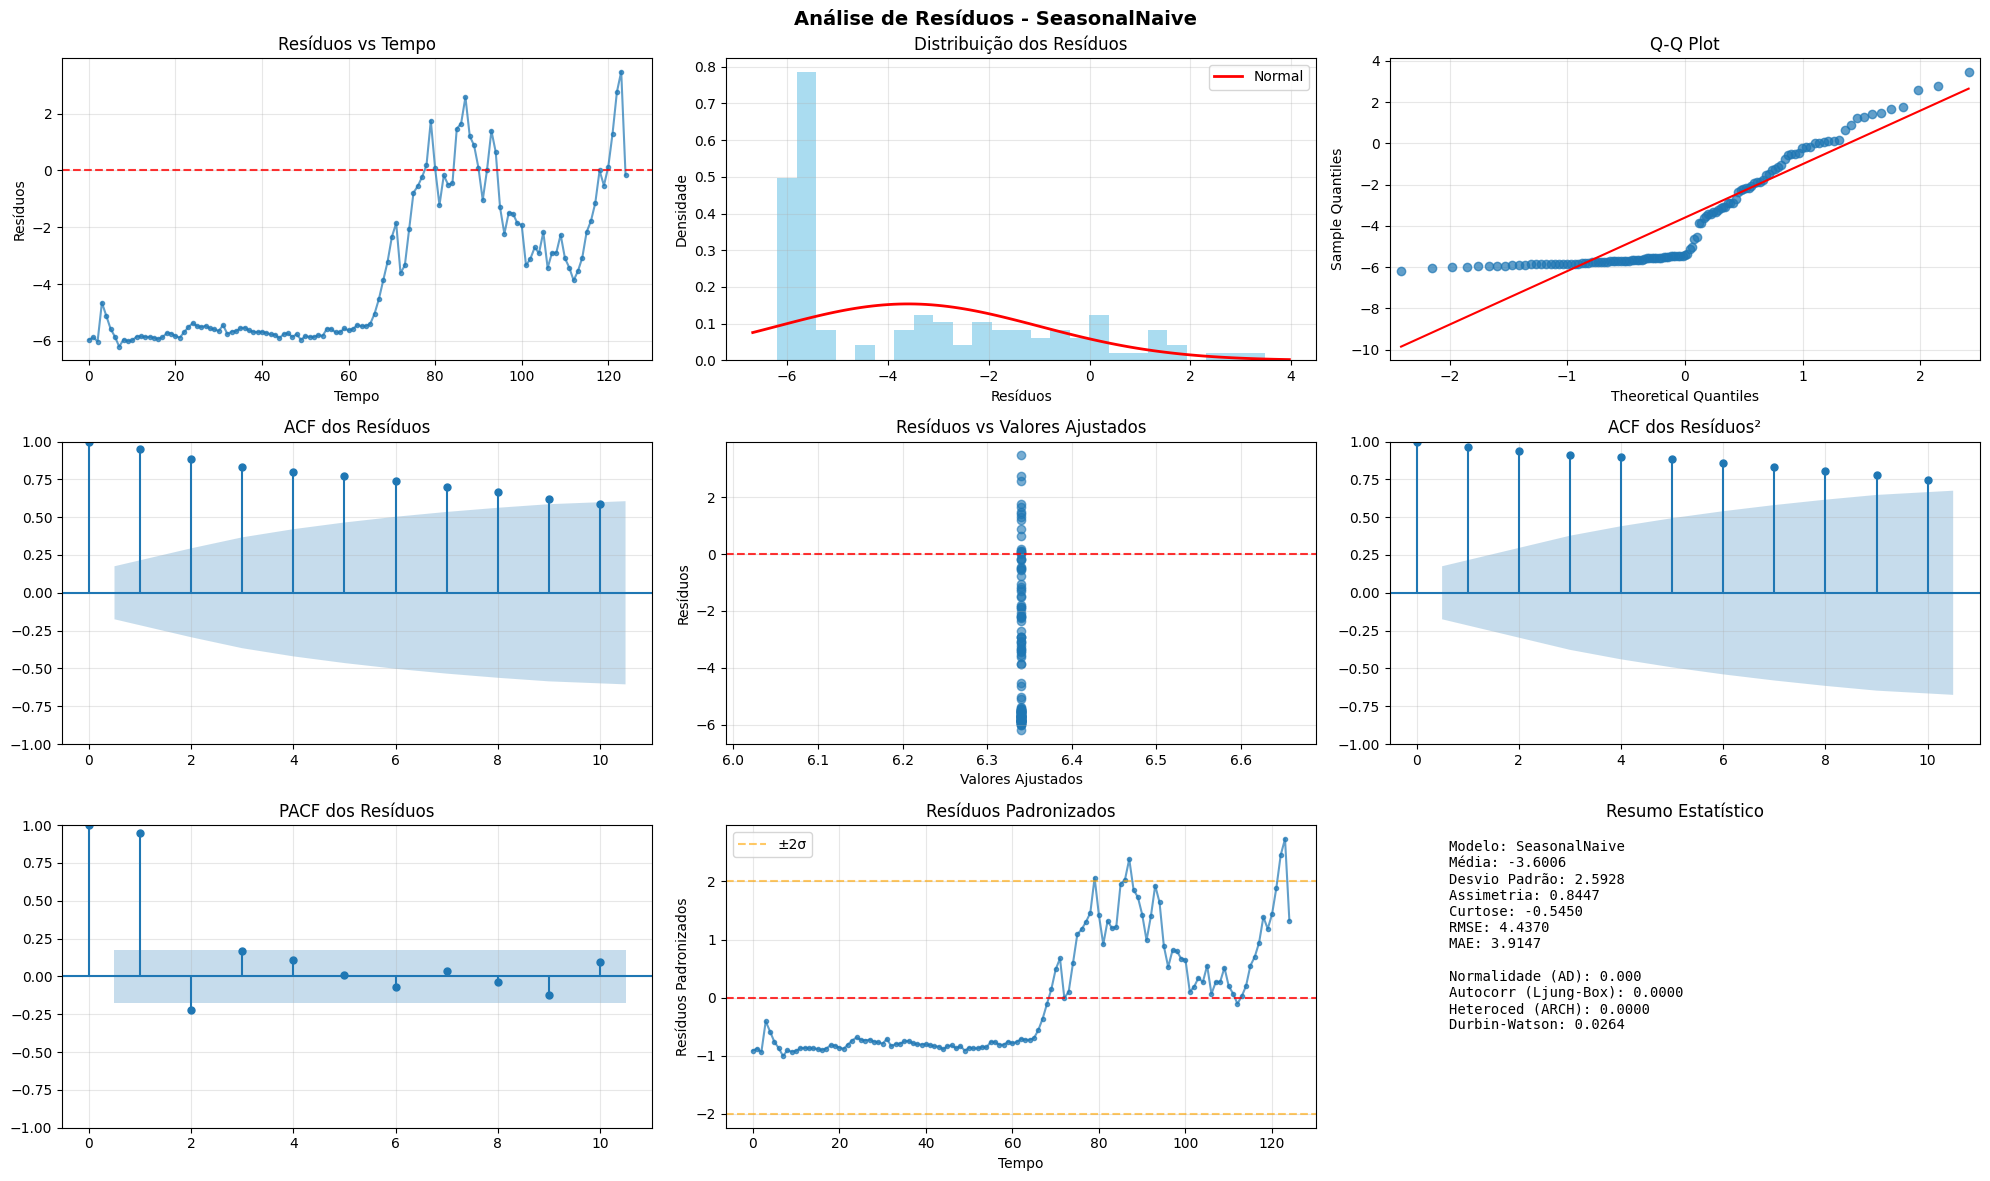


DIAGNÓSTICO DOS RESÍDUOS:
--------------------------------------------------

ERROS:
  RMSE: 4.4370
  MAE:  3.9147
  MSE:  19.6874
--------------------------------------------------

   Analisando: AutoReg_AR5

ANÁLISE DE RESÍDUOS: AutoReg_AR5


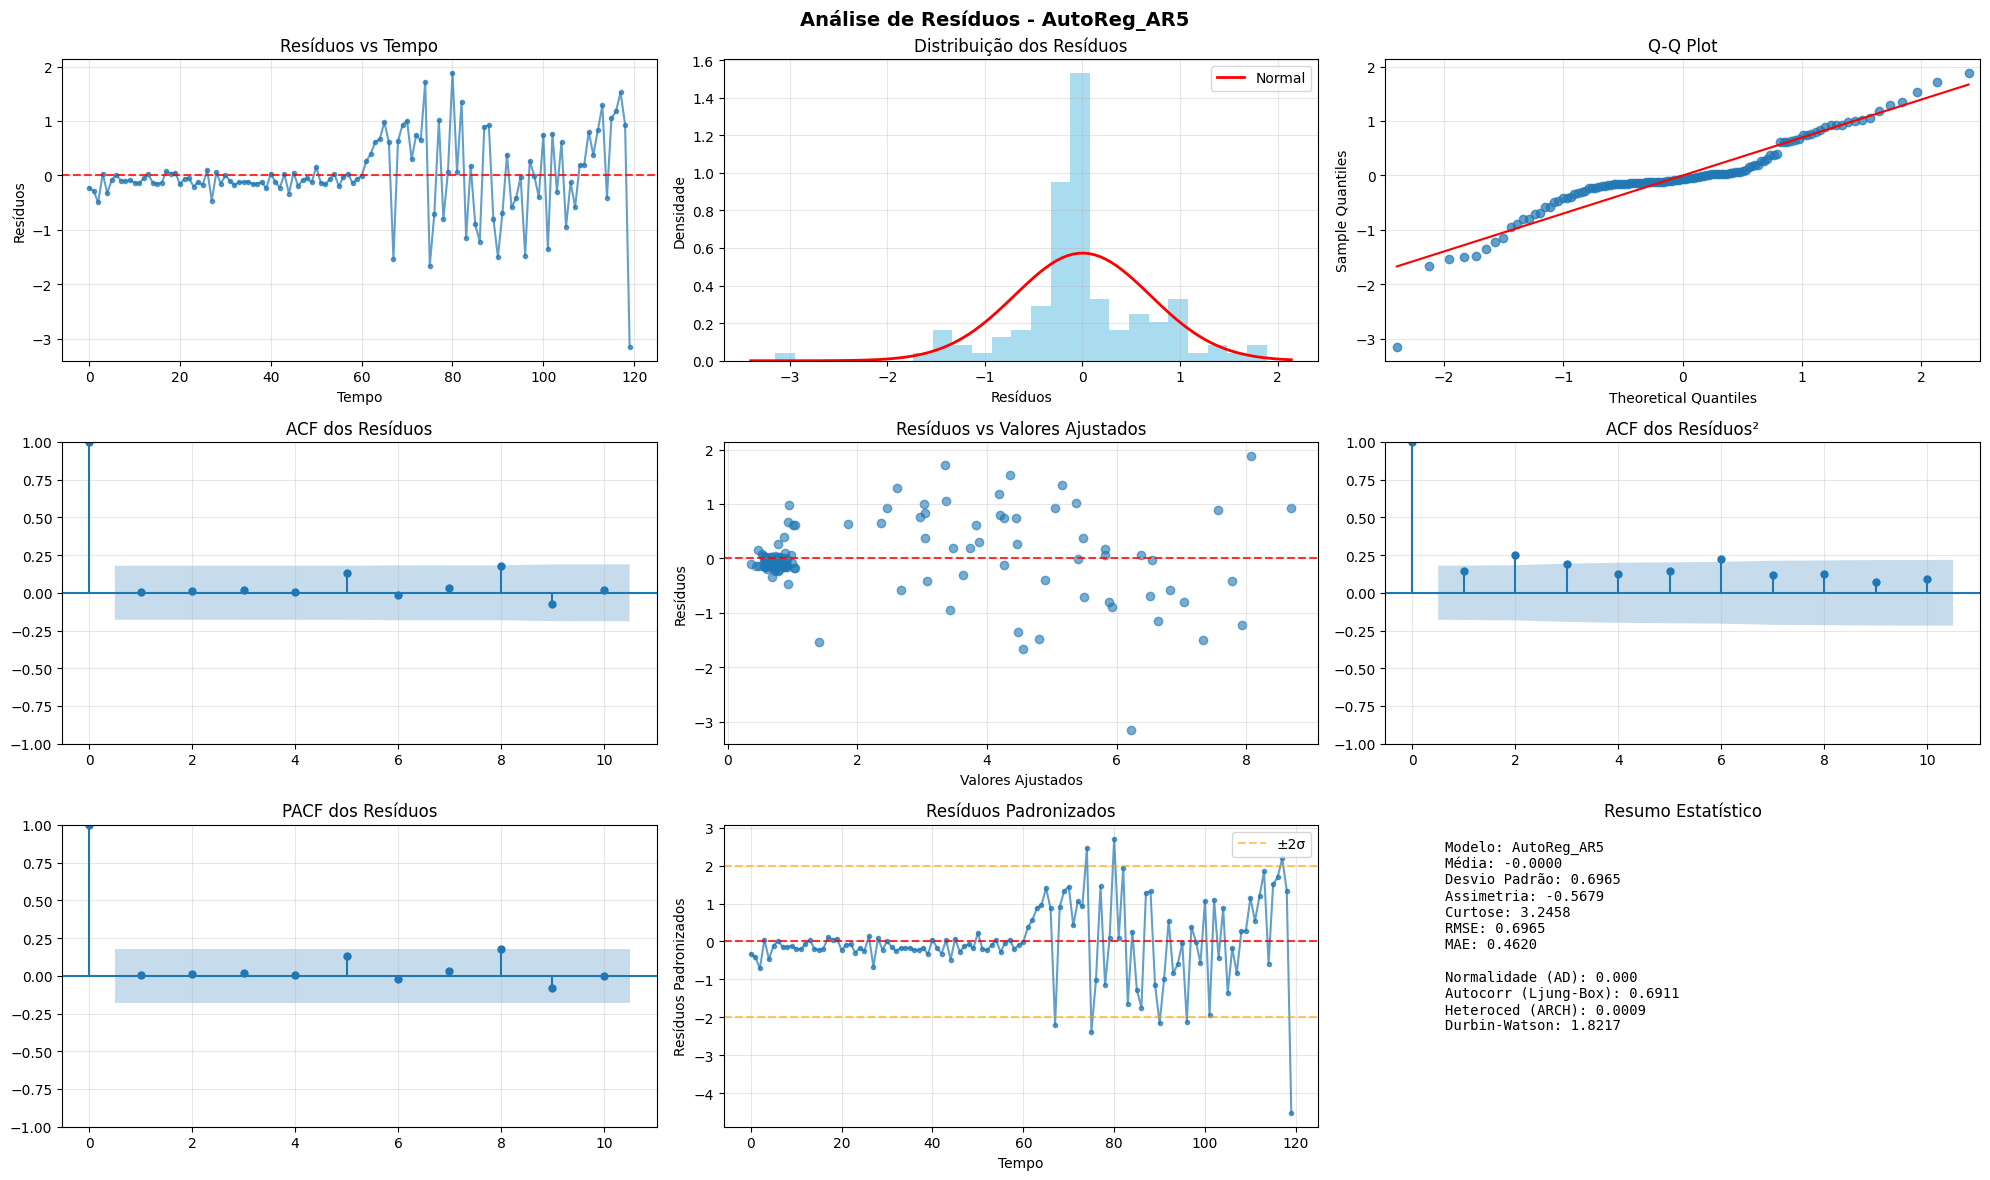


DIAGNÓSTICO DOS RESÍDUOS:
--------------------------------------------------

ERROS:
  RMSE: 0.6965
  MAE:  0.4620
  MSE:  0.4851
--------------------------------------------------

   Analisando: ExponentialSmoothing

ANÁLISE DE RESÍDUOS: ExponentialSmoothing


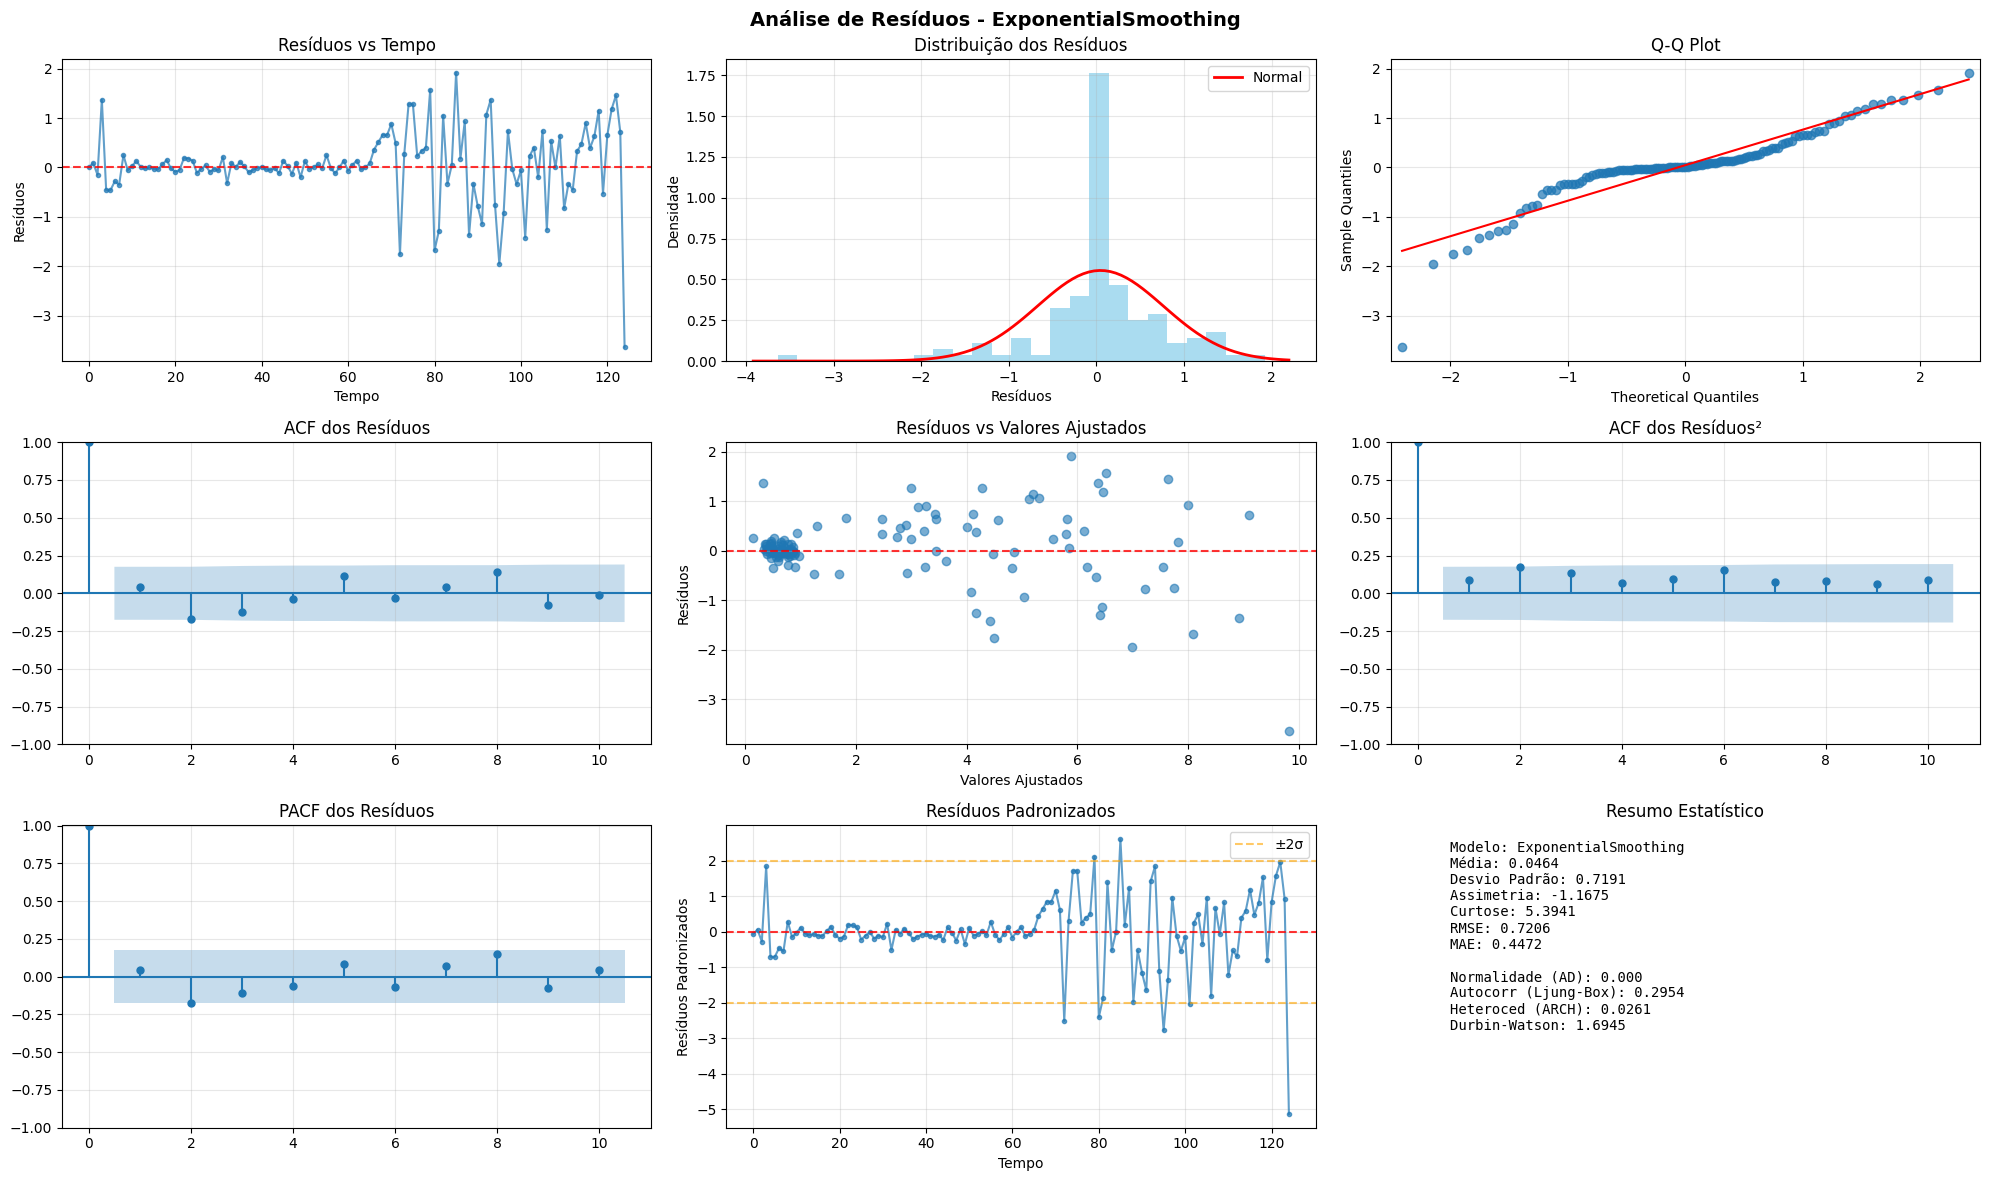


DIAGNÓSTICO DOS RESÍDUOS:
--------------------------------------------------

ERROS:
  RMSE: 0.7206
  MAE:  0.4472
  MSE:  0.5192
--------------------------------------------------

   Analisando: Regression

ANÁLISE DE RESÍDUOS: Regression


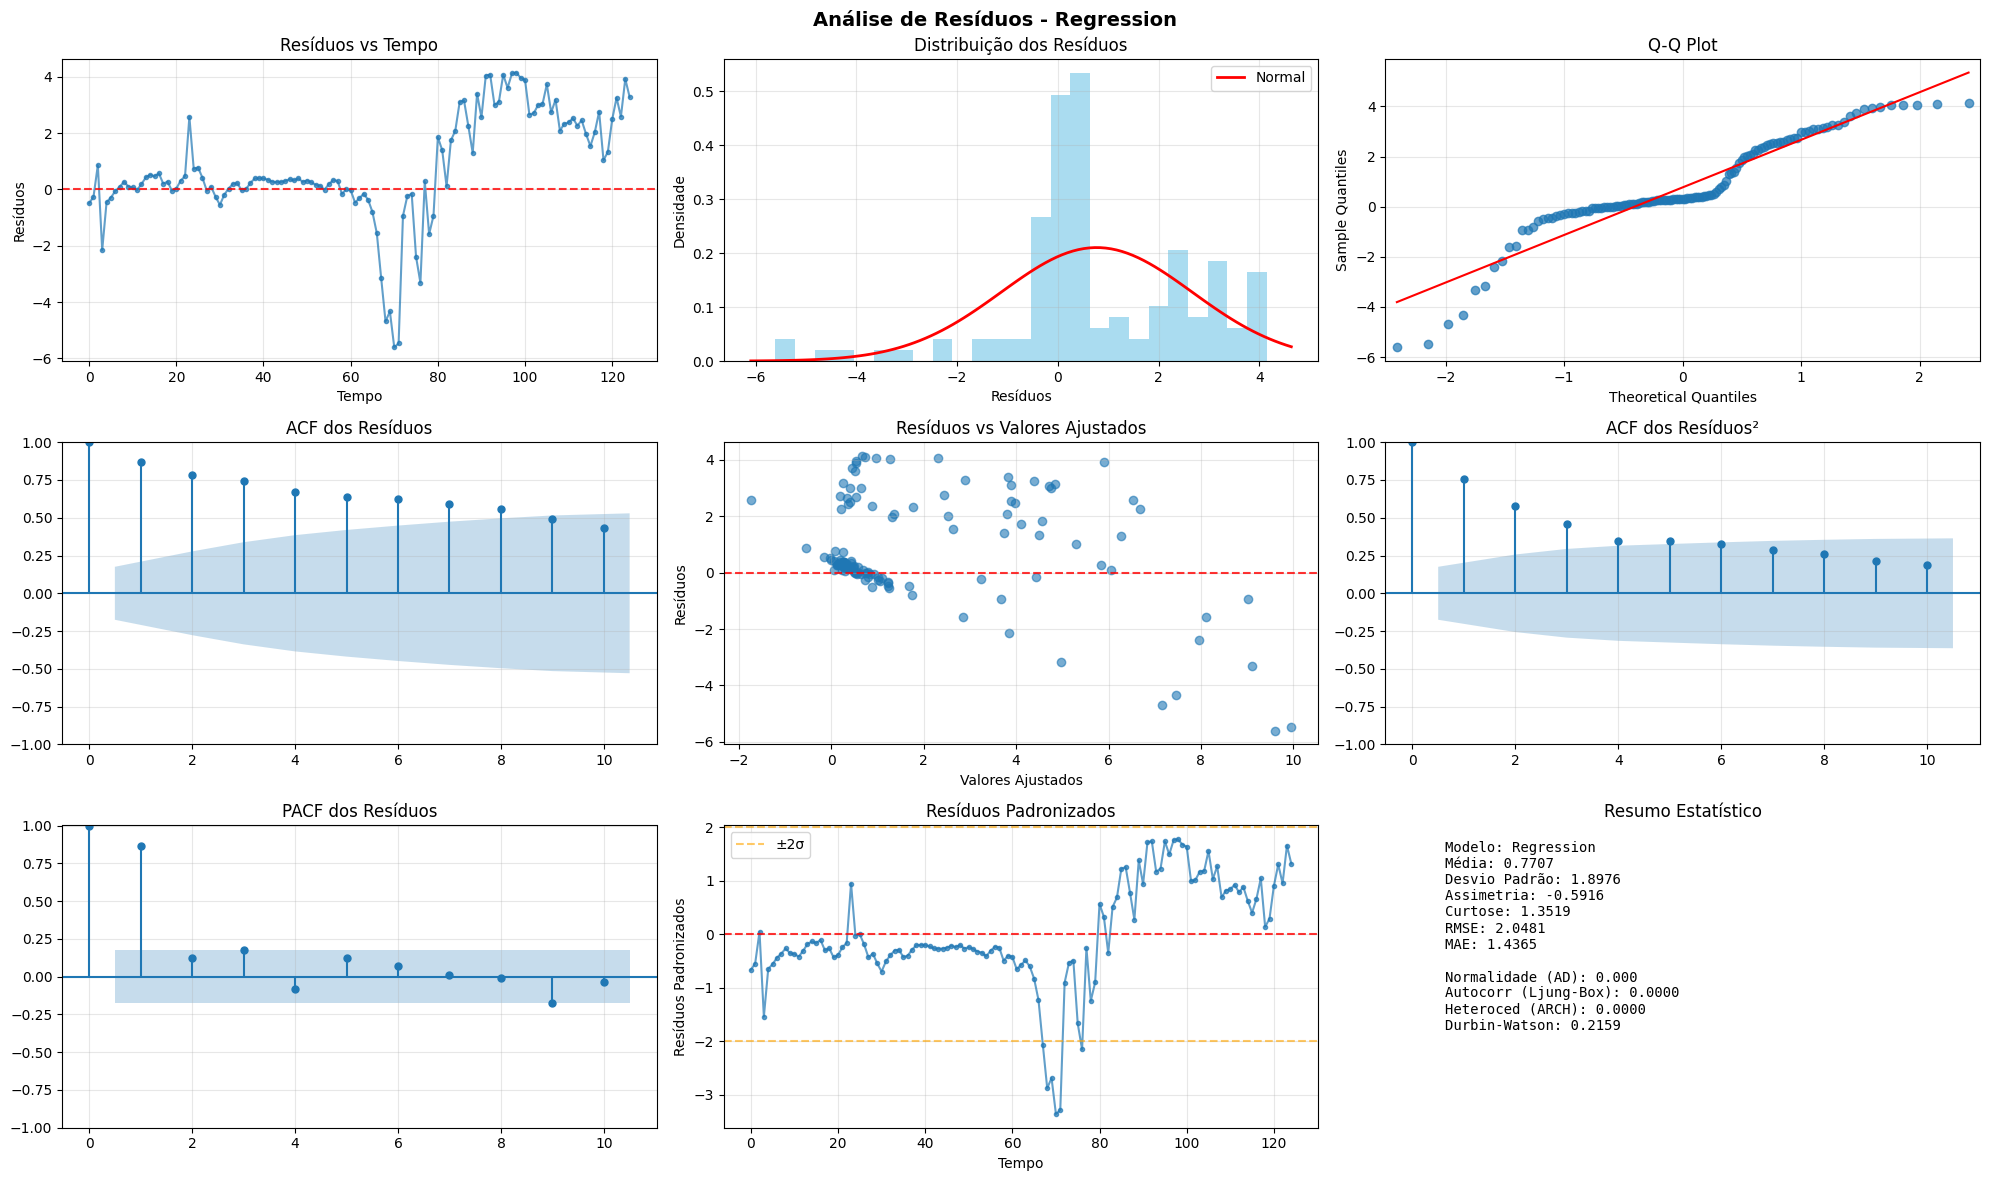


DIAGNÓSTICO DOS RESÍDUOS:
--------------------------------------------------

ERROS:
  RMSE: 2.0481
  MAE:  1.4365
  MSE:  4.1949
--------------------------------------------------

5. COMPARAÇÃO E RANKING DE MODELOS...


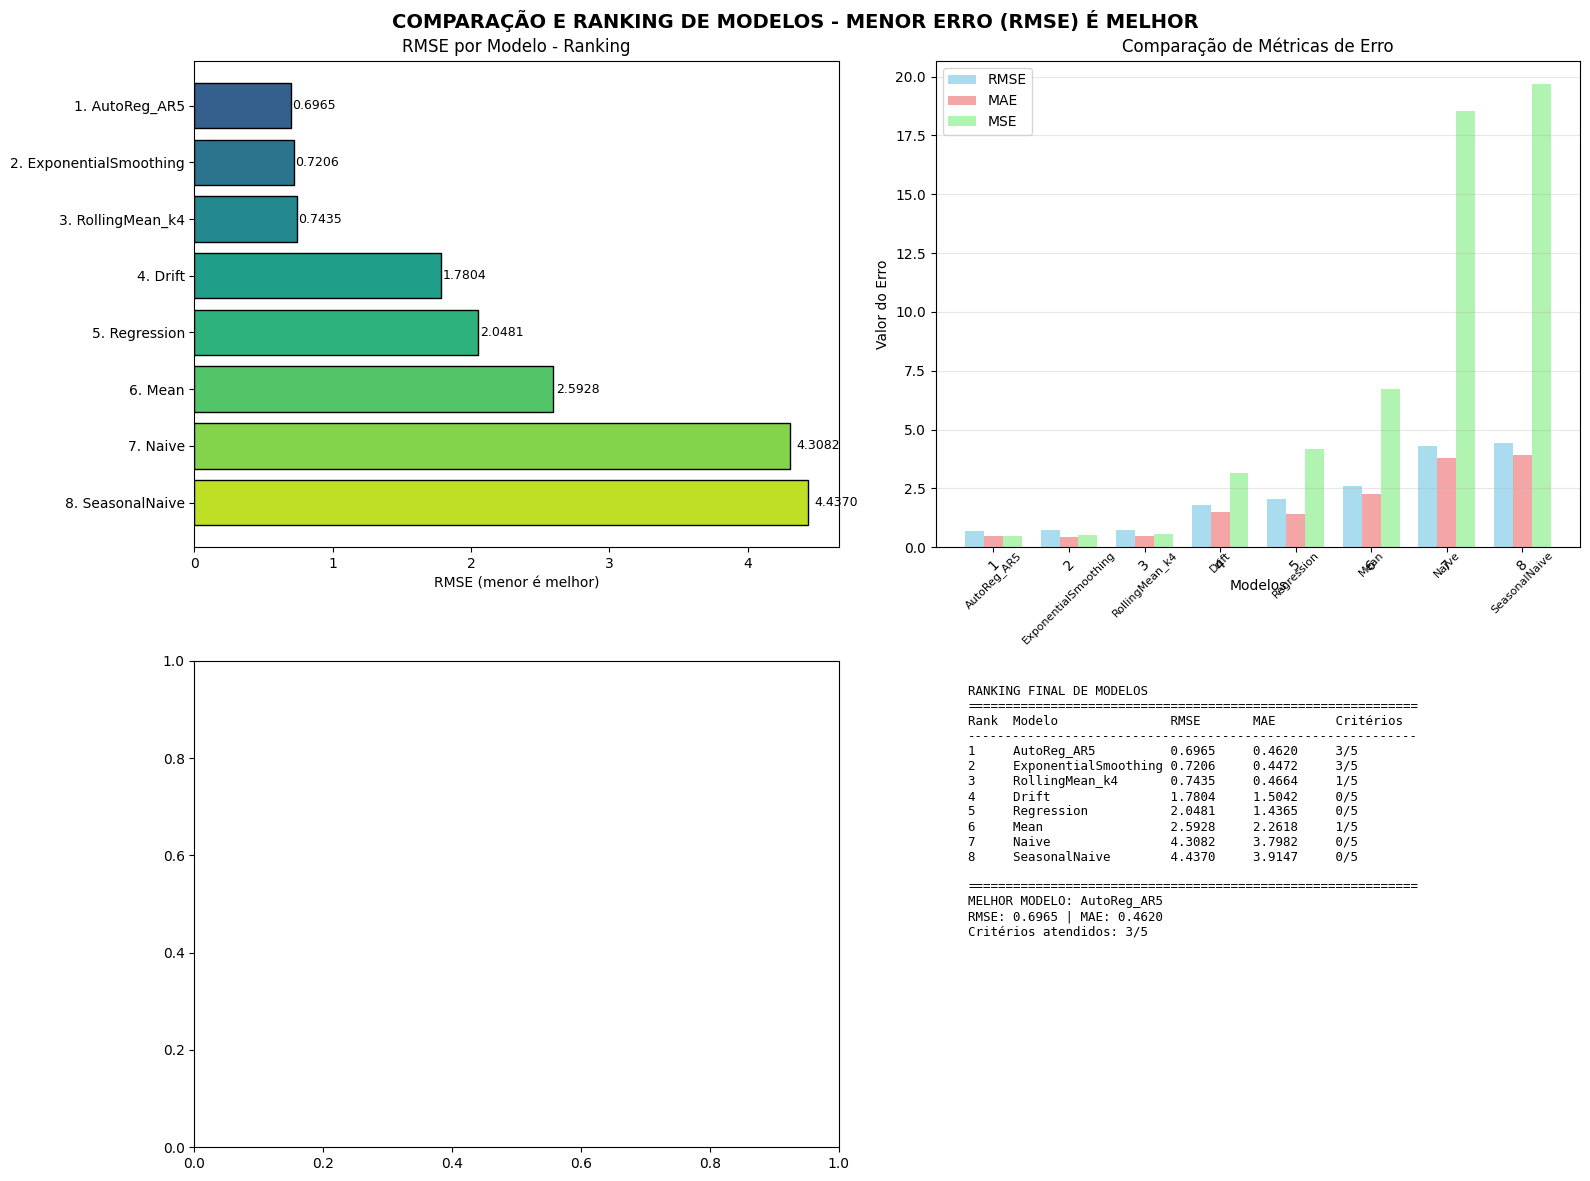


RANKING FINAL DE MODELOS (ordenado por RMSE - menor é melhor)
 Rank_Final               Modelo     RMSE      MAE
          1          AutoReg_AR5 0.696475 0.462022
          2 ExponentialSmoothing 0.720588 0.447200
          3       RollingMean_k4 0.743508 0.466425
          4                Drift 1.780420 1.504191
          5           Regression 2.048135 1.436473
          6                 Mean 2.592825 2.261833
          7                Naive 4.308218 3.798240
          8        SeasonalNaive 4.437043 3.914720

 MELHOR MODELO: AutoReg_AR5
   RMSE: 0.6965
   MAE:  0.4620

 Análise concluída!


In [62]:
results = execute_complete_analysis("data_updated.csv", target_column="volume", test_size=0.2)

#